In [1]:
%%capture
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.plot([0,1],[1,0])
from neuronunit.optimisation import make_sim_tests
import numpy as np
from IPython.display import display, HTML
from neuronunit.plottools import plot_score_history1
from neuronunit.optimisation.optimization_management import check_binary_match
import pandas as pd
from collections import OrderedDict


# Simulated Data 
and select model parameters that are free to vary

In [2]:
%%capture
fps = ['c','a','b']
model_type="RAW"
sim_tests, OM, target = make_sim_tests.test_all_objective_test(fps,model_type=model_type)

# Meta Parameters

In [3]:
MU = 10 
NGEN = 50


In [4]:
OM = target.dtc_to_opt_man()
out = OM.random_search(target,100)
#temp = {k:v[0] for k,v in out.items() if isinstance(v,Iterable)}
#frame = pd.DataFrame([temp])


warning please add whether or not model should be scored on rheobase to protocol


In [5]:
display(out['frame'])


,RheobaseTest,TimeConstantTest,RestingPotentialTest,InputResistanceTest,CapacitanceTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest
0,0.724863,0.497112,0.598178,0.051552,0.497138,174.695044,0.477313,0.600725


In [6]:
results = sim_tests.optimize(backend=model_type,\
        protocol={'allen': False, 'elephant': True},\
            MU=MU,NGEN=NGEN,plot=True,free_parameters=fps)



GA Generation Progress: 100%|██████████| 49/49 [03:00<00:00,  3.68s/it]


# Analyse Results

In [7]:
opt = results['pf'][0].dtc
hof = results['hof'][0].dtc
OM.tests = opt.tests
opt = OM.format_test(opt)
opt.self_evaluate()
opt = OM.get_agreement(opt)
display(opt.agreement)

,RheobaseTest,TimeConstantTest,RestingPotentialTest,InputResistanceTest,CapacitanceTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest,total
observations,131.396484375 pA,2250.237725614159 ms,-65.2261863636364 mV,28495143.850294366 kg*m**2/(s**3*A**2),7.896916532291564e-08 s**4*A**2/(kg*m**2),0.00034 s,50.140316341758094 mV,-29.001977407775495 mV,NaN
predictions,131.396484375 pA,3421.0597800883984 ms,-65.2261863636364 mV,29671786.854100898 kg*m**2/(s**3*A**2),1.1529672267161012e-07 s**4*A**2/(kg*m**2),0.00033000000000000005 s,49.290688580538756 mV,-28.152349646556157 mV,NaN
scores,0,0.229735,0,0.0121663,0.200791,0.0118026,0.00678295,0.0117556,2.532872


# Compare scores above to random scores below

In [22]:
# This should be more succint than above.
agreement = opt.get_agreement().agreement
display(out['frame'])


,RheobaseTest,TimeConstantTest,RestingPotentialTest,InputResistanceTest,CapacitanceTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest
0,0.724863,0.497112,0.598178,0.051552,0.497138,174.695044,0.477313,0.600725


# Look at evolution History

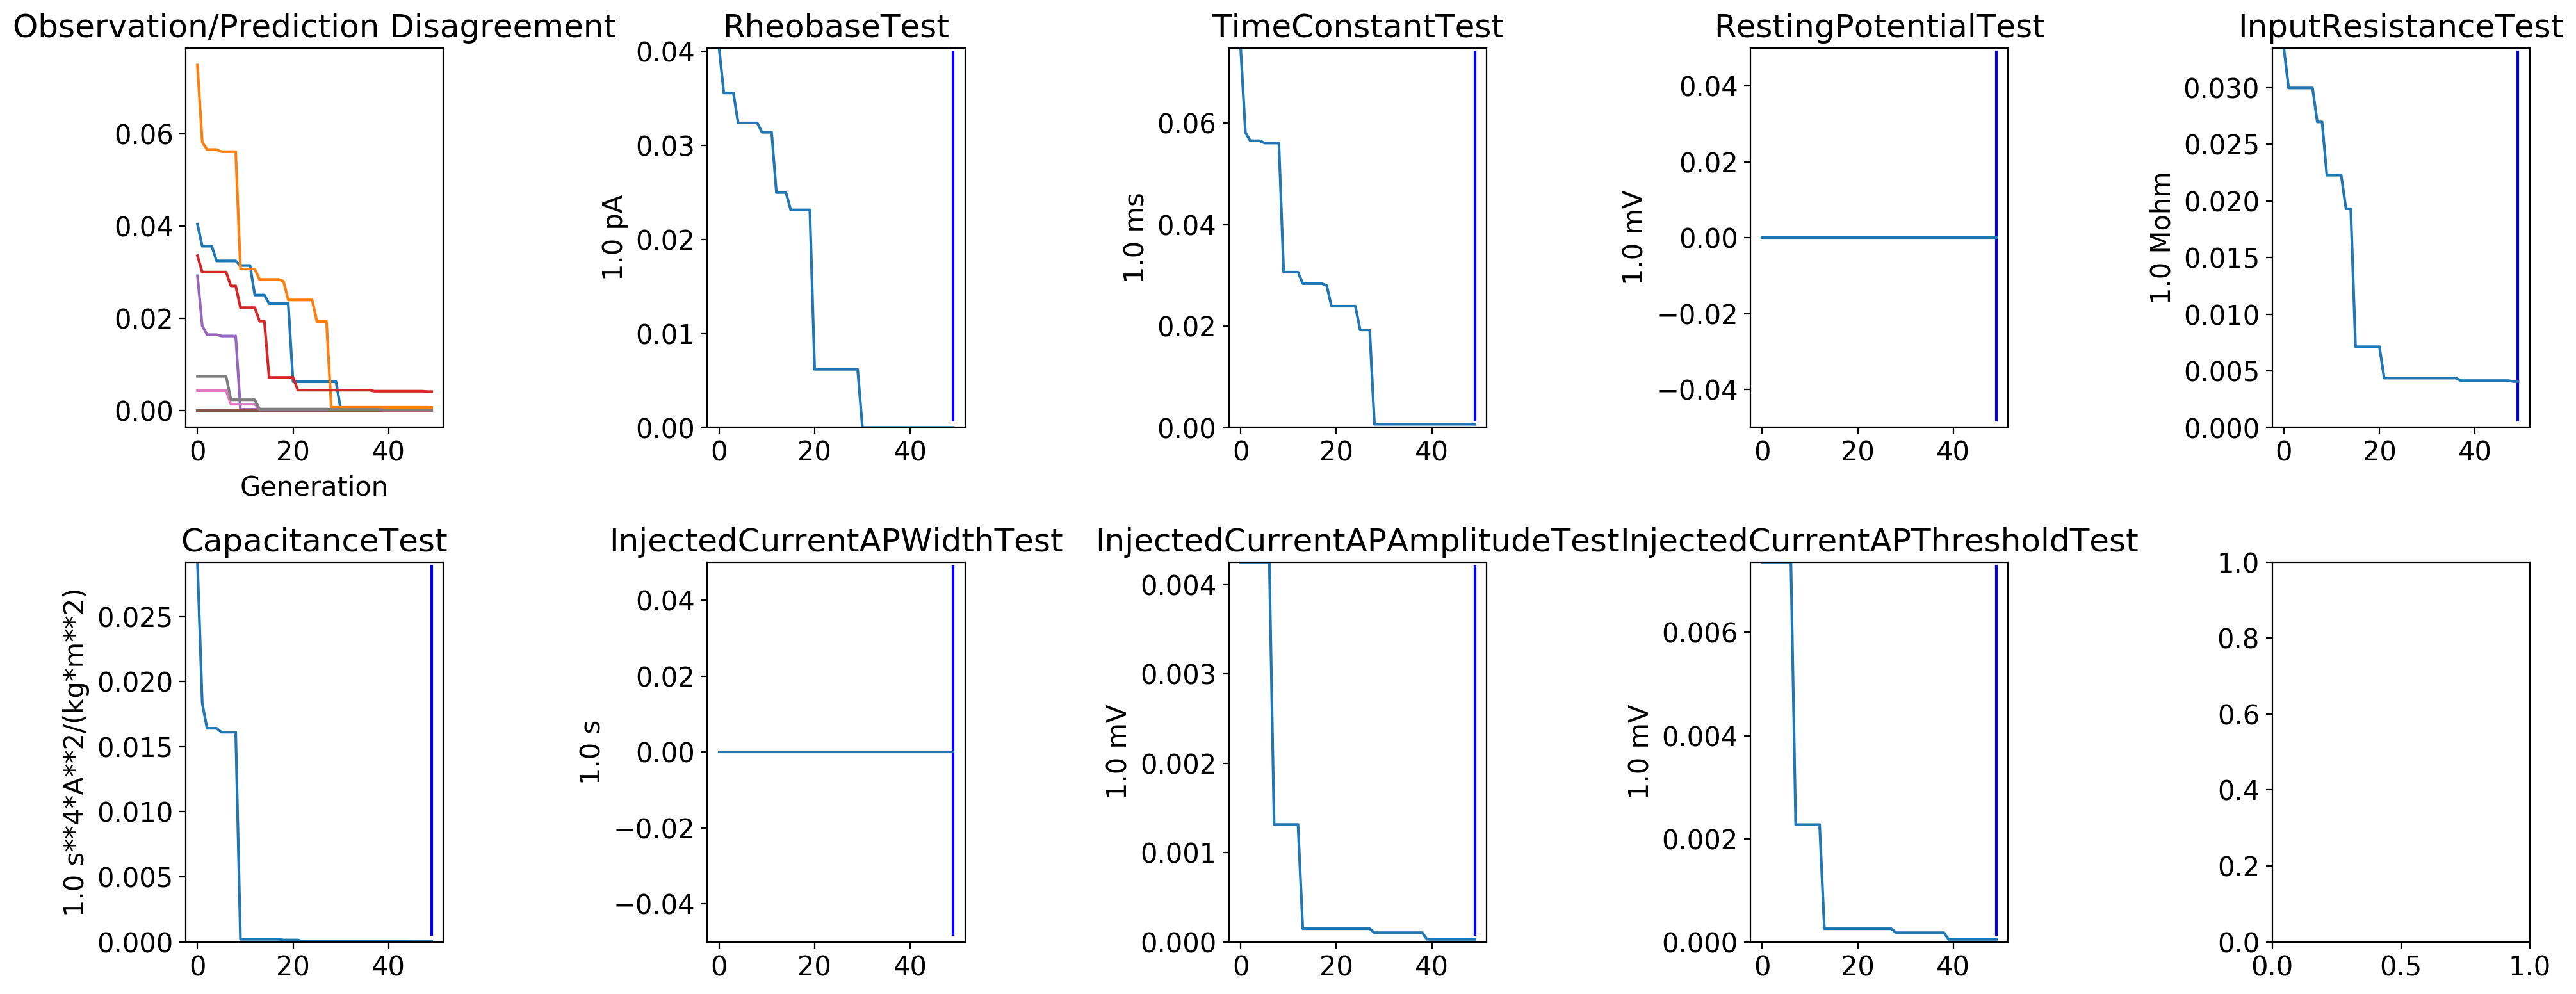

In [9]:
plt = plot_score_history1(results)
from neuronunit.optimisation.optimization_management import check_binary_match

<Figure size 640x480 with 0 Axes>

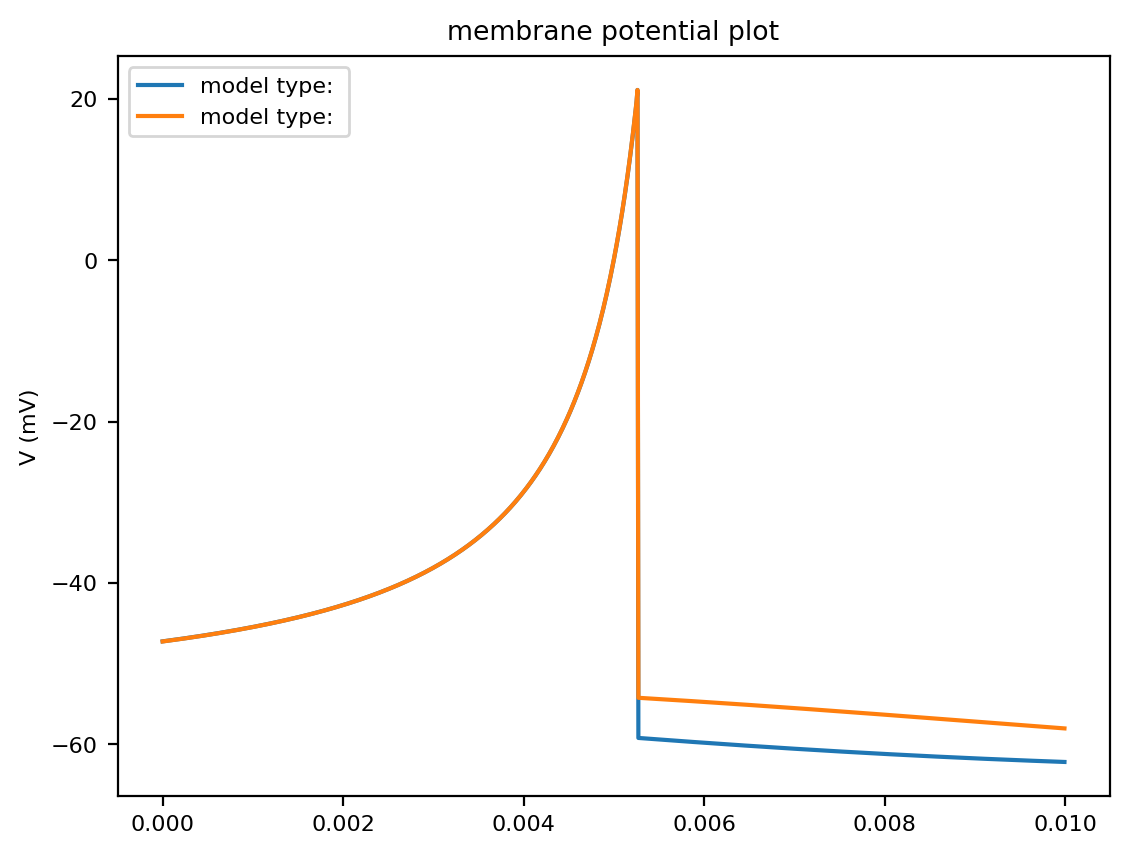

In [10]:
model = target.dtc_to_model()
check_binary_match(opt,target,snippets=True)
target = OM.format_test(target)
simulated_data_tests = target.tests

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

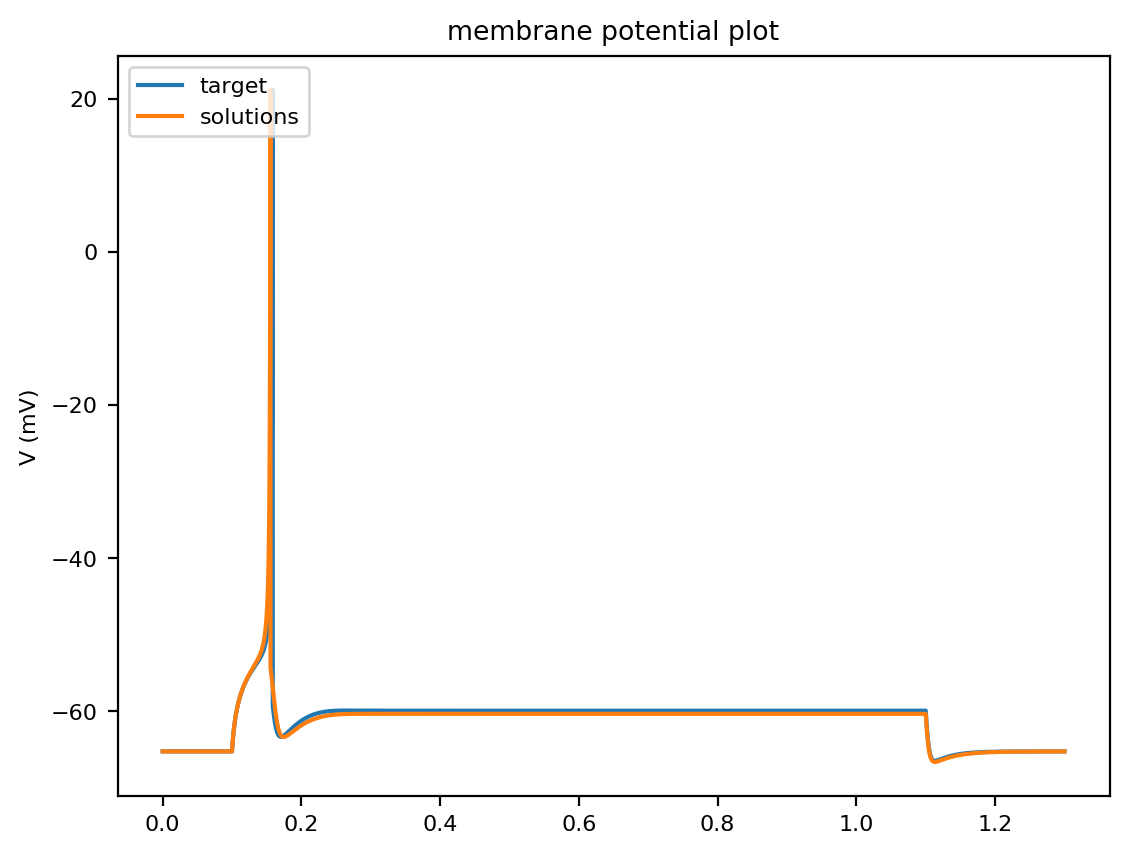

In [11]:
check_binary_match(opt,target,snippets=False)

In [12]:
try:
    opt.attrs.pop('dt',None)
    opt.attrs.pop('Iext',None)
except:
    pass


In [13]:
display(pd.DataFrame([opt.attrs]))
import copy
temp = {}
for k in opt.attrs.keys():
    temp[k] = target.attrs[k]
display(pd.DataFrame([temp]))

,a,b,c
0,0.029508,8.865483,-59.18974


,a,b,c
0,0.02409,10.276476,-54.212523


In [14]:
display(pd.DataFrame([{k.name:v for k,v in opt.SA.items()}]))

,RheobaseTest,TimeConstantTest,RestingPotentialTest,InputResistanceTest,CapacitanceTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest
0,0.0,0.229735,0.0,0.012166,0.200791,0.011803,0.006783,0.011756


What where the values of model parameters that where held constant?


In [15]:
df0 = opt.dtc_to_model().default_attrs
df1 = target.dtc_to_model().default_attrs
hc = {}

try:
    df0.attrs.pop('dt',None)
    df0.attrs.pop('Iext',None)
    opt.attrs.pop('dt',None)
    opt.attrs.pop('Iext',None)

except:
    pass

for k,v in df0.items():
    if k not in opt.attrs.keys():
        assert df0[k] == df1[k]
        hc[k] = v        
display("Held constant:")
display(pd.DataFrame([hc]))        

'Held constant:'

,C,d,k,vPeak,vr,vt,dt,Iext
0,89.796071,10,1.6,21.138339,-65.226186,-50,0.01,[]


If the Pareto Front encircles the best solution without sampling directly on top of it.
Does piercing the center get us closer to the hall of fame?
Below, plot HOF[0]/PF[0] are they the same model? 

In [16]:
# check_binary_match(opt,hof,snippets=True)


# Exploring the neighbourhood of 
the Optimal solution is now syntatically easy

## Make ranges to explore:

In [31]:
from neuronunit.optimisation.model_parameters import MODEL_PARAMS
a_range = MODEL_PARAMS["RAW"]['a']
grid_a = np.linspace(a_range[0],a_range[1],25)




## Mutate a parameter in a dimension of interest.

100%|██████████| 25/25 [00:17<00:00,  1.44it/s]


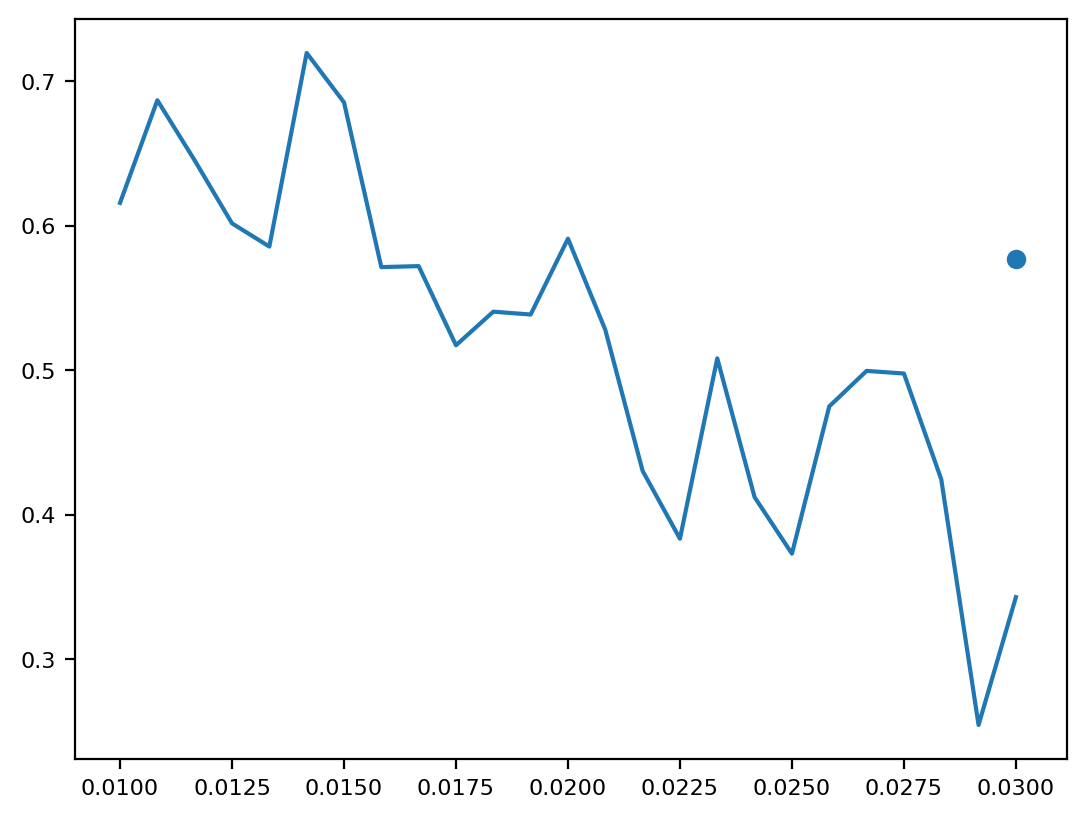

In [33]:
opt_sum0 = np.sum(opt.SA.values)
for_scatter0 = (opt.attrs['a'],opt_sum0)
from tqdm import tqdm
collect = []
mutant = copy.copy(opt)
for a in tqdm(grid_a):
    # non random mutation
    mutant.attrs['a'] = a
    # Evaluate NU test suite
    mutant.self_evaluate()
    # sum components (optional)
    fit = np.sum(mutant.SA.values)
    collect.append(fit)
plt.plot(grid_a,collect)
plt.scatter(for_scatter0[0],for_scatter0[1],label='optima')
    

The above plot seemed to have two steep wells, of low error about the optima.

It might not be reasonable to expect to sample every such well, as the stochastic nature of the GA is not garunteed to sample small and and focused pockets of error change.

In [27]:
b_range = MODEL_PARAMS["RAW"]['b']
grid_b = np.linspace(b_range[0],b_range[1],30);

100%|██████████| 25/25 [01:38<00:00,  3.95s/it]


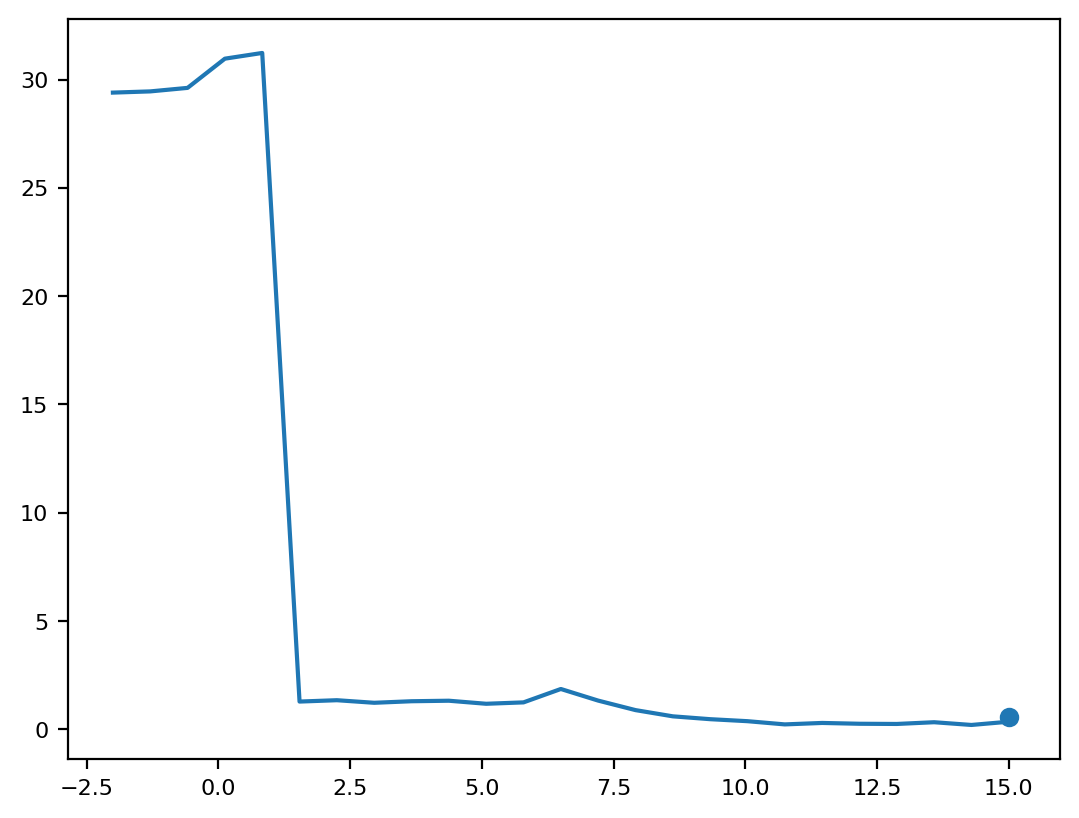

In [28]:
opt_sum = np.sum(opt.SA.values)
for_scatter1 = (opt.attrs['b'],opt_sum)
from tqdm import tqdm
collect = []
mutant = copy.copy(opt)
for b in tqdm(grid_b):
    # non random mutation
    mutant.attrs['b'] = b
    # Evaluate NU test suite
    mutant.self_evaluate()
    # sum components (optional)
    fit = np.sum(mutant.SA.values)
    collect.append(fit)
plt.plot(grid_b,collect)
plt.scatter(for_scatter1[0],for_scatter1[1],label='optima')
